In [4]:
# =========================
# 0) Install deps
# =========================
!pip -q install gdown rasterio tifffile

import os
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import rasterio # для чтения окнами из больших TIFF
from rasterio.windows import Window

import tifffile as tiff
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
from contextlib import nullcontext
from torch.cuda.amp import autocast as cuda_autocast

In [5]:
from torch.cuda.amp import autocast, GradScaler

In [6]:
# =========================
# 1) Download + unzip
# =========================

GDRIVE_URL = "https://drive.google.com/file/d/1f2pChGHdZ24yb-CFrAAbF8KbS3Ix35Du/view?"
OUT_ZIP = "/content/dataset.zip"
OUT_DIR = "/content/dataset"

!gdown --fuzzy "{GDRIVE_URL}" -O "{OUT_ZIP}"
!mkdir -p "{OUT_DIR}"
!unzip -q "{OUT_ZIP}" -d "{OUT_DIR}"

Downloading...
From (original): https://drive.google.com/uc?id=1f2pChGHdZ24yb-CFrAAbF8KbS3Ix35Du
From (redirected): https://drive.google.com/uc?id=1f2pChGHdZ24yb-CFrAAbF8KbS3Ix35Du&confirm=t&uuid=bbecfa74-9afc-45f6-8975-0b9194c446e2
To: /content/dataset.zip
100% 11.0G/11.0G [06:07<00:00, 30.0MB/s]


In [7]:
# =========================
# 2) Dataset
# =========================
IMG_EXTS = {".tif"}

def list_pairs_simple(root: str) -> List[Tuple[str, str]]:
    img_dir = os.path.join(root, "images")
    gt_dir  = os.path.join(root, "gt")
    pairs = []

    for fn in sorted(os.listdir(img_dir)):
        if os.path.splitext(fn.lower())[1] not in IMG_EXTS:
            continue
        img_path = os.path.join(img_dir, fn)
        gt_path  = os.path.join(gt_dir, fn)
        if not os.path.exists(gt_path):
            raise FileNotFoundError(f"Missing mask for {fn}: {gt_path}")
        pairs.append((img_path, gt_path))

    if not pairs:
        raise RuntimeError("No pairs found.")
    return pairs


def split_by_scene(pairs, val_ratio=0.15, seed=42):
    rng = random.Random(seed)
    idxs = list(range(len(pairs)))
    rng.shuffle(idxs)
    n_val = max(1, int(len(pairs) * val_ratio))
    val = set(idxs[:n_val])
    train_pairs = [p for i, p in enumerate(pairs) if i not in val]
    val_pairs   = [p for i, p in enumerate(pairs) if i in val]
    return train_pairs, val_pairs


def to_float01_hwc(img_hwc: np.ndarray) -> np.ndarray:
    # для RGB uint8/uint16
    if img_hwc.dtype == np.uint8:
        return img_hwc.astype(np.float32) / 255.0
    if img_hwc.dtype == np.uint16:
        return img_hwc.astype(np.float32) / 65535.0
    img = img_hwc.astype(np.float32)
    mx = np.nanmax(img)
    if mx > 1.5:
        img = img / (mx + 1e-6)
    return img


@dataclass
class CropConfig:
    patch_size: int = 256
    scale_jitter: Optional[Tuple[float, float]] = (0.75, 1.5)  # None for val
    augment: bool = True


class SatBuildingsDataset(Dataset):
    def __init__(
        self,
        root: str,
        split: str = "train",
        val_ratio: float = 0.15,
        seed: int = 42,
        samples_per_epoch: int = 4000,
        crop: CropConfig = CropConfig(),
    ):
        assert split in ("train", "val")
        self.split = split
        self.samples_per_epoch = samples_per_epoch
        self.crop = crop

        pairs = list_pairs_simple(root)
        train_pairs, val_pairs = split_by_scene(pairs, val_ratio=val_ratio, seed=seed)
        self.pairs = train_pairs if split == "train" else val_pairs

        self.rng = random.Random(seed if split == "val" else seed + 1337)
        self._sizes = {}  # cache W,H per image

    def __len__(self):
        return self.samples_per_epoch if self.split == "train" else max(1, len(self.pairs) * 50)

    def _get_size(self, img_path: str):
        if img_path in self._sizes:
            return self._sizes[img_path]
        with rasterio.open(img_path) as src:
            self._sizes[img_path] = (src.width, src.height)
        return self._sizes[img_path]

    def _sample_window(self, W, H, patch, scale_range):
        if scale_range is None:
            src = patch
        else:
            s = self.rng.uniform(*scale_range)
            src = int(round(patch / s))
            src = max(16, min(src, W, H))
        x = self.rng.randint(0, max(0, W - src))
        y = self.rng.randint(0, max(0, H - src))
        return x, y, src

    def _augment(self, x: torch.Tensor, y: torch.Tensor):
        if not self.crop.augment:
            return x, y
        # flips
        if self.rng.random() < 0.5:
            x = torch.flip(x, dims=[2]); y = torch.flip(y, dims=[1])
        if self.rng.random() < 0.5:
            x = torch.flip(x, dims=[1]); y = torch.flip(y, dims=[0])
        # rot90
        k = self.rng.randint(0, 3)
        if k:
            x = torch.rot90(x, k, dims=[1, 2])
            y = torch.rot90(y, k, dims=[0, 1])
        return x, y

    def __getitem__(self, idx):
        if self.split == "train":
            img_path, msk_path = self.pairs[self.rng.randrange(len(self.pairs))]
        else:
            img_path, msk_path = self.pairs[idx % len(self.pairs)]

        W, H = self._get_size(img_path)
        patch = self.crop.patch_size
        x0, y0, src_sz = self._sample_window(W, H, patch, self.crop.scale_jitter)

        # Read window
        with rasterio.open(img_path) as im:
            # RGB: первые 3 бэнда (если их меньше — берём сколько есть)
            bands = [1, 2, 3] if im.count >= 3 else list(range(1, im.count + 1))
            img = im.read(bands, window=Window(x0, y0, src_sz, src_sz))  # CHW

        with rasterio.open(msk_path) as ms:
            mask = ms.read(1, window=Window(x0, y0, src_sz, src_sz))     # HW uint8 0/255

        # Normalize image
        img_hwc = np.transpose(img, (1, 2, 0))
        img_hwc = to_float01_hwc(img_hwc)
        img_chw = np.transpose(img_hwc, (2, 0, 1))

        # Binarize mask (0/255 -> 0/1)
        mask = (mask > 0).astype(np.uint8)

        x = torch.from_numpy(img_chw).float()          # C,src,src
        y = torch.from_numpy(mask).long()              # src,src

        # Resize to patch if scale jitter changed src_sz
        if src_sz != patch:
            x = torch.nn.functional.interpolate(x.unsqueeze(0), size=(patch, patch), mode="bilinear", align_corners=False).squeeze(0)
            y = torch.nn.functional.interpolate(y.unsqueeze(0).unsqueeze(0).float(), size=(patch, patch), mode="nearest").squeeze(0).squeeze(0).long()

        x, y = self._augment(x, y)
        return x, y

In [10]:
# =========================
# 3) Make DataLoaders
# =========================
crop_train = CropConfig(patch_size=256, scale_jitter=(0.5, 1.5), augment=True)
crop_val   = CropConfig(patch_size=256, scale_jitter=None, augment=False)

train_ds = SatBuildingsDataset(
    OUT_DIR, split="train", val_ratio=0.15, seed=42,
    samples_per_epoch=4000, crop=crop_train
)

val_ds = SatBuildingsDataset(
    OUT_DIR, split="val", val_ratio=0.15, seed=42,
    samples_per_epoch=1000, crop=crop_val
)

train_loader = DataLoader(
    train_ds, batch_size=8, shuffle=True,
    num_workers=2, pin_memory=True, persistent_workers=True
)

val_loader = DataLoader(
    val_ds, batch_size=8, shuffle=False,
    num_workers=2, pin_memory=True, persistent_workers=True
)

# sanity check
xb, yb = next(iter(train_loader))
print("X:", xb.shape, xb.dtype, xb.min().item(), xb.max().item())
print("Y:", yb.shape, yb.dtype, torch.unique(yb)[:10])


X: torch.Size([8, 3, 256, 256]) torch.float32 0.00047951494343578815 0.9995390176773071
Y: torch.Size([8, 256, 256]) torch.int64 tensor([0, 1])


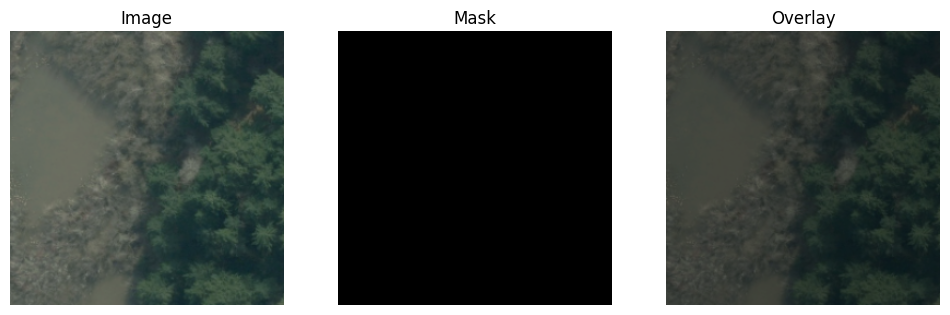

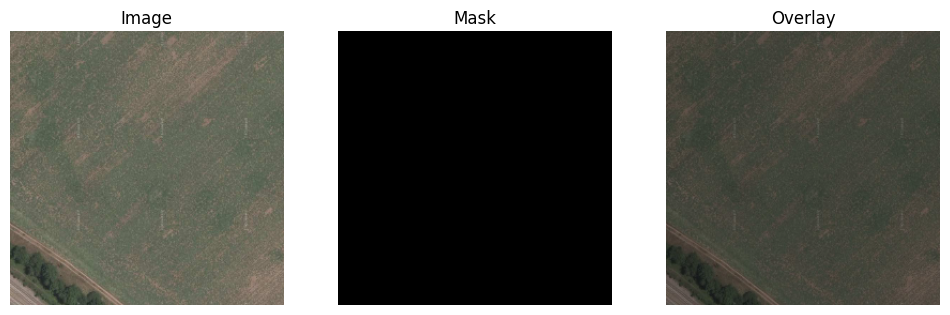

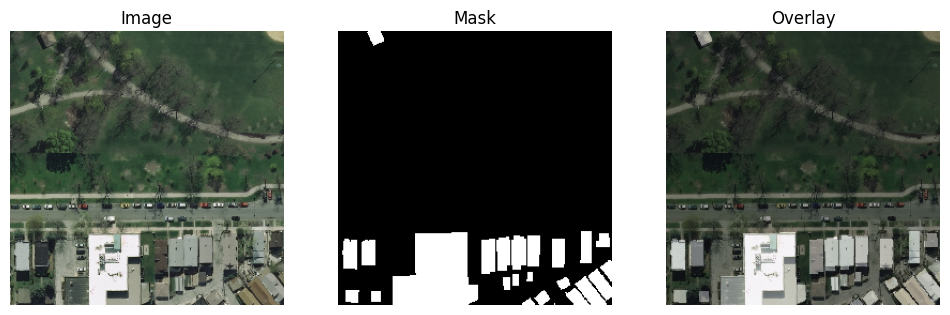

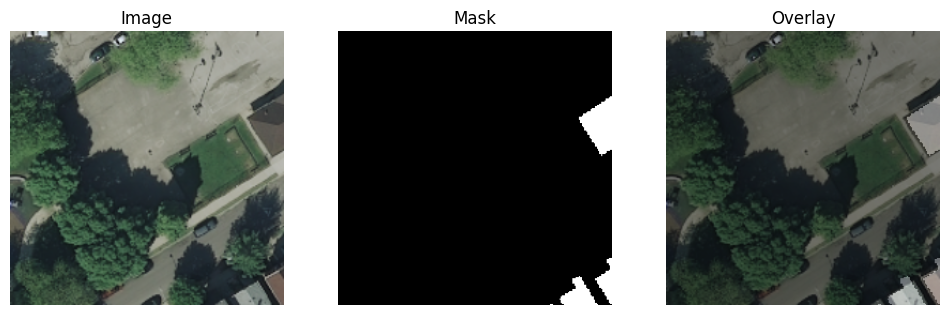

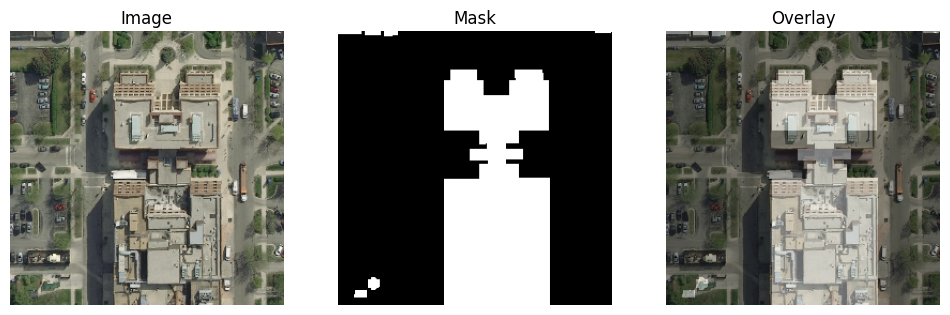

In [11]:
xb, yb = next(iter(train_loader))

n = 5
for i in range(n):
    img = xb[i].permute(1,2,0).cpu().numpy()  # HWC
    msk = yb[i].cpu().numpy().astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Mask"); plt.imshow(msk, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay")
    plt.imshow(img);
    plt.imshow(msk, alpha=0.35, cmap="gray")  # полупрозрачная маска
    plt.axis("off")
    plt.show()


In [12]:
fracs = []
for _ in range(50):  # 50 батчей
    xb, yb = next(iter(train_loader))
    fracs.append((yb.float().mean(dim=(1,2))).cpu().numpy())
fracs = np.concatenate(fracs)

print("mean building fraction:", fracs.mean())
print("median:", np.median(fracs))
print("min/max:", fracs.min(), fracs.max())
print("empty patches fraction:", (fracs==0).mean())


mean building fraction: 0.16170456
median: 0.08407593
min/max: 0.0 1.0
empty patches fraction: 0.3225


1) Модель + loss (BCE + Dice) + метрики

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# --- Model: DeepLabV3, 1 output channel for binary segmentation ---
model = deeplabv3_resnet50(weights=None, num_classes=1)  # logits 1xHxW
model = model.to(device)

# --- Dice loss ---
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        # logits: [B,1,H,W], targets: [B,H,W] {0,1}
        probs = torch.sigmoid(logits)
        targets = targets.float().unsqueeze(1)  # [B,1,H,W]
        num = 2 * (probs * targets).sum(dim=(2,3))
        den = (probs + targets).sum(dim=(2,3)) + self.eps
        dice = num / den
        return 1 - dice.mean()

# pos_weight ~ (1-p)/p; у тебя mean building ~0.16 => ~5
pos_weight = torch.tensor([5.0], device=device)

bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
dice = DiceLoss()

def loss_fn(logits, targets):
    # logits: [B,1,H,W], targets: [B,H,W]
    return bce(logits, targets.float().unsqueeze(1)) + dice(logits, targets)

@torch.no_grad()
def metrics_from_logits(logits, targets, thr=0.75, eps=1e-6):
    # logits: [B,1,H,W], targets: [B,H,W]
    probs = torch.sigmoid(logits)
    preds = (probs > thr).long().squeeze(1)  # [B,H,W]
    t = targets.long()

    tp = ((preds == 1) & (t == 1)).sum().item()
    fp = ((preds == 1) & (t == 0)).sum().item()
    fn = ((preds == 0) & (t == 1)).sum().item()

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    iou       = tp / (tp + fp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    return precision, recall, iou, f1


device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


2) Optimizer + AMP + training loop (с grad accumulation)

In [26]:
import math
from torch.cuda.amp import autocast, GradScaler

# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4) # обучение на lr 2e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4) # дообучение на пониженном lr 5e-5

scaler = GradScaler(enabled=(device.type == "cuda"))

# Настройки:
BATCH = 8          # ставим 8
ACCUM = 4          # эффективный batch = BATCH*ACCUM
EPOCHS = 5
MAX_GRAD_NORM = 1.0

def train_one_epoch(model, loader):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    total_loss = 0.0
    total_steps = 0

    for step, (x, y) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with autocast(enabled=(device.type=="cuda")):
            out = model(x)["out"]              # [B,1,H,W]
            loss = loss_fn(out, y) / ACCUM     # делим на accum

        scaler.scale(loss).backward()

        if (step + 1) % ACCUM == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item() * ACCUM
        total_steps += 1

    return total_loss / max(1, total_steps)

@torch.no_grad()
def evaluate(model, loader, max_batches=50):
    model.eval()
    total_loss = 0.0
    total = 0

    P = R = IoU = F1 = 0.0

    for i, (x, y) in enumerate(loader):
        if i >= max_batches:  # чтобы валидация была быстрой
            break

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with autocast(enabled=(device.type=="cuda")):
            out = model(x)["out"]
            loss = loss_fn(out, y)

        p, r, iou, f1 = metrics_from_logits(out, y)

        total_loss += loss.item()
        P += p; R += r; IoU += iou; F1 += f1
        total += 1

    if total == 0:
        return 0, 0, 0, 0, 0

    return (total_loss/total, P/total, R/total, IoU/total, F1/total)

/tmp/ipython-input-547220390.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


3) Подогнать DataLoader под batch

In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=2, pin_memory=True, persistent_workers=True)

val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                        num_workers=2, pin_memory=True, persistent_workers=True)
print(train_loader.batch_size)

8


4) Запуск обучения

In [23]:
best_iou = -1.0
best_epoch = 0

In [24]:
# Загрузка модели

BEST_PATH = "/content/best_model.pt"
LAST_PATH = "/content/last_model.pt"

resume_path = LAST_PATH if os.path.exists(LAST_PATH) else (BEST_PATH if os.path.exists(BEST_PATH) else None)

if resume_path is not None:
    ckpt = torch.load(resume_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    scaler.load_state_dict(ckpt["scaler_state_dict"])

    best_iou = ckpt.get("best_iou", -1.0)
    start_epoch = ckpt["epoch"] + 1

    print(f"Resuming from {resume_path}")
    print("start_epoch:", start_epoch, "best_iou so far:", best_iou)
else:
    best_iou = -1.0
    start_epoch = 1
    print("No checkpoint found. Starting from scratch.")

# Продолжение обучения

num_more_epochs = 10  # сколько будем обучать

for epoch in range(start_epoch, start_epoch + num_more_epochs):
    tr_loss = train_one_epoch(model, train_loader)
    val_loss, p, r, iou, f1 = evaluate(model, val_loader, max_batches=200)

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | "
          f"P={p:.3f} R={r:.3f} IoU={iou:.3f} F1={f1:.3f}")

    # best
    if iou > best_iou:
        best_iou = iou
        torch.save({
            "epoch": epoch,
            "best_iou": best_iou,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict(),
        }, BEST_PATH)
        print(f"  ✅ Saved best checkpoint: epoch={epoch}, IoU={best_iou:.4f} -> {BEST_PATH}")

    # last
    torch.save({
        "epoch": epoch,
        "best_iou": best_iou,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
    }, LAST_PATH)


Resuming from /content/best_model.pt
start_epoch: 48 best_iou so far: 0.7492710899752789


/tmp/ipython-input-3103699284.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-3103699284.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


Epoch 48 | train_loss=0.7484 | val_loss=0.7999 | P=0.819 R=0.869 IoU=0.728 F1=0.839
Epoch 49 | train_loss=0.7202 | val_loss=0.8030 | P=0.811 R=0.884 IoU=0.732 F1=0.842
Epoch 50 | train_loss=0.7002 | val_loss=0.8529 | P=0.783 R=0.880 IoU=0.706 F1=0.822
Epoch 51 | train_loss=0.6992 | val_loss=0.8198 | P=0.830 R=0.864 IoU=0.735 F1=0.843
Epoch 52 | train_loss=0.7462 | val_loss=0.8779 | P=0.821 R=0.845 IoU=0.712 F1=0.828
Epoch 53 | train_loss=0.7467 | val_loss=0.8341 | P=0.841 R=0.853 IoU=0.733 F1=0.842
Epoch 54 | train_loss=0.7095 | val_loss=0.8240 | P=0.842 R=0.855 IoU=0.736 F1=0.845
Epoch 55 | train_loss=0.7277 | val_loss=0.8289 | P=0.819 R=0.880 IoU=0.737 F1=0.845
Epoch 56 | train_loss=0.6935 | val_loss=0.7757 | P=0.822 R=0.883 IoU=0.741 F1=0.849
Epoch 57 | train_loss=0.7041 | val_loss=0.7865 | P=0.788 R=0.895 IoU=0.721 F1=0.835


Проверка

/tmp/ipython-input-101897491.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  amp_ctx = cuda_autocast(enabled=(device.type == "cuda")) if device.type == "cuda" else nullcontext()


Checkpoint: best | epoch=47 | best_iou=0.7492710899752789 | thr=0.8
Batch totals: GT area=104,358 px | Pred area=126,930 px | Δ=+22,572 px | Pred/GT=1.216
--------------------------------------------------------------------------------


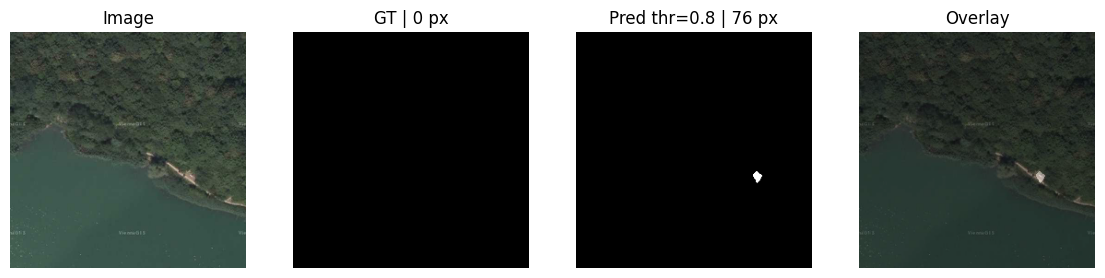

Patch 0: GT area=0 px | Pred area=76 px | Δ=+76 px | Pred/GT=76000000.000


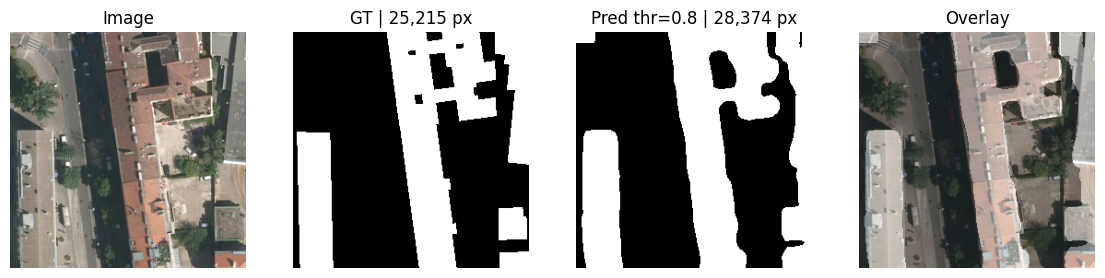

Patch 1: GT area=25,215 px | Pred area=28,374 px | Δ=+3,159 px | Pred/GT=1.125


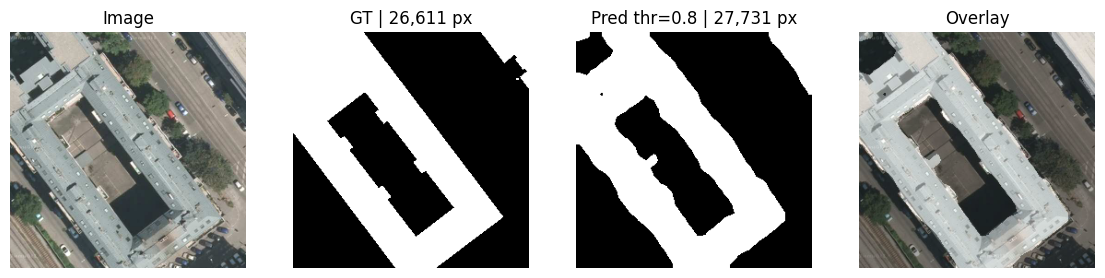

Patch 2: GT area=26,611 px | Pred area=27,731 px | Δ=+1,120 px | Pred/GT=1.042


In [20]:
# --- Paths ---
BEST_PATH = "/content/best_model.pt"
LAST_PATH = "/content/last_model.pt"

# --- UI state ---
_state = {
    "current_ckpt": None,
    "val_iter": None,
    "thr": 0.7,
    "n": 3,
}

def _load_checkpoint_into_model(which: str):
    assert which in ("best", "last")
    path = BEST_PATH if which == "best" else LAST_PATH
    if not os.path.exists(path):
        raise FileNotFoundError(f"Checkpoint not found: {path}")

    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])

    _state["current_ckpt"] = {
        "which": which,
        "path": path,
        "epoch": ckpt.get("epoch"),
        "best_iou": ckpt.get("best_iou"),
    }

    # reset iterator so "next" starts fresh for the selected checkpoint (optional but nice)
    _state["val_iter"] = iter(val_loader)
    return _state["current_ckpt"]

def _fmt_area_stats(gt_area: int, pr_area: int):
    diff = pr_area - gt_area
    ratio = (pr_area / (gt_area + 1e-6))  # avoid div-by-zero
    return f"GT area={gt_area:,} px | Pred area={pr_area:,} px | Δ={diff:+,} px | Pred/GT={ratio:.3f}"

@torch.no_grad()
def _show_next_batch(n=3, thr=0.75):
    if _state["val_iter"] is None:
        _state["val_iter"] = iter(val_loader)

    try:
        xb, yb = next(_state["val_iter"])
    except StopIteration:
        _state["val_iter"] = iter(val_loader)
        xb, yb = next(_state["val_iter"])

    xb = xb.to(device)
    yb = yb.to(device)

    amp_ctx = cuda_autocast(enabled=(device.type == "cuda")) if device.type == "cuda" else nullcontext()
    with amp_ctx:
        logits = model(xb)["out"]  # [B,1,H,W]
        probs = torch.sigmoid(logits)
        preds = (probs > thr).long().squeeze(1)  # [B,H,W]

    # --- Area stats (BATCH level, on GPU for speed) ---
    gt_area_batch = int((yb == 1).sum().item())
    pr_area_batch = int((preds == 1).sum().item())

    xb = xb.cpu()
    yb = yb.cpu()
    preds = preds.cpu()

    # Header
    ck = _state["current_ckpt"]
    if ck is not None:
        print(f"Checkpoint: {ck['which']} | epoch={ck['epoch']} | best_iou={ck['best_iou']} | thr={thr}")
    else:
        print(f"Checkpoint: (not loaded) | thr={thr}")

    print("Batch totals:", _fmt_area_stats(gt_area_batch, pr_area_batch))
    print("-" * 80)

    for i in range(min(n, xb.shape[0])):
        img = xb[i].permute(1, 2, 0).numpy()
        gt  = yb[i].numpy().astype(np.uint8)
        pr  = preds[i].numpy().astype(np.uint8)

        # --- Area stats (PATCH level) ---
        gt_area = int(gt.sum())
        pr_area = int(pr.sum())

        plt.figure(figsize=(14, 4))
        plt.subplot(1, 4, 1); plt.title("Image"); plt.imshow(img); plt.axis("off")
        plt.subplot(1, 4, 2); plt.title(f"GT | {gt_area:,} px"); plt.imshow(gt, cmap="gray"); plt.axis("off")
        plt.subplot(1, 4, 3); plt.title(f"Pred thr={thr} | {pr_area:,} px"); plt.imshow(pr, cmap="gray"); plt.axis("off")
        plt.subplot(1, 4, 4); plt.title("Overlay"); plt.imshow(img); plt.imshow(pr, cmap="gray", alpha=0.35); plt.axis("off")
        plt.show()

        print(f"Patch {i}: " + _fmt_area_stats(gt_area, pr_area))
    print("=" * 80)

# --- Widgets ---
dd = widgets.Dropdown(
    options=[("best", "best"), ("last", "last")],
    value="best",
    description="Checkpoint:",
    layout=widgets.Layout(width="260px")
)

thr_w = widgets.FloatSlider(
    value=_state["thr"], min=0.3, max=0.9, step=0.05,
    description="thr:", continuous_update=False,
    layout=widgets.Layout(width="380px")
)

btn = widgets.Button(
    description="Показать следующие 3 примера",
    button_style="primary",
    layout=widgets.Layout(width="260px")
)

out = widgets.Output()

def _render_initial():
    out.clear_output(wait=True)
    with out:
        _load_checkpoint_into_model(dd.value)
        _state["thr"] = float(thr_w.value)
        _show_next_batch(n=_state["n"], thr=_state["thr"])

def _on_dd_change(change):
    if change["name"] == "value":
        _render_initial()

def _on_thr_change(change):
    if change["name"] == "value":
        _state["thr"] = float(change["new"])

def _on_btn_click(_):
    out.clear_output(wait=True)
    with out:
        _show_next_batch(n=_state["n"], thr=float(thr_w.value))

dd.observe(_on_dd_change, names="value")
thr_w.observe(_on_thr_change, names="value")
btn.on_click(_on_btn_click)

ui = widgets.HBox([dd, thr_w, btn])
display(ui, out)

# Load default and show first 3
_render_initial()

In [19]:
# --- choose checkpoint for inference ---

WHICH = "best"  # "best" or "last"
BEST_PATH = "/content/best_model.pt"
LAST_PATH = "/content/last_model.pt"

path = BEST_PATH if WHICH == "best" else LAST_PATH
assert os.path.exists(path), f"Missing: {path}"

ckpt = torch.load(path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
print(f"Loaded {WHICH}: epoch={ckpt.get('epoch')} best_iou={ckpt.get('best_iou')}")


@torch.no_grad()
def threshold_rescan_for_inference(model, loader, thresholds, max_batches=None):
    """
    Re-scan thresholds by summing TP/FP/FN over pixels.
    max_batches=None -> full val, else fast scan on first N batches.

    Adds: total GT area vs Pred area (pixels) for each threshold.
    """
    acc = {t: {"tp": 0, "fp": 0, "fn": 0, "gt_area": 0, "pred_area": 0} for t in thresholds}

    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()  # [B,H,W]

        # GT building pixels for this batch (same for all thresholds)
        gt_area_batch = int((y == 1).sum().item())

        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)["out"]  # [B,1,H,W]
        probs = torch.sigmoid(logits)

        for t in thresholds:
            preds = (probs > t).long().squeeze(1)  # [B,H,W]

            tp = ((preds == 1) & (y == 1)).sum().item()
            fp = ((preds == 1) & (y == 0)).sum().item()
            fn = ((preds == 0) & (y == 1)).sum().item()

            pred_area_batch = int((preds == 1).sum().item())

            acc[t]["tp"] += tp
            acc[t]["fp"] += fp
            acc[t]["fn"] += fn
            acc[t]["gt_area"] += gt_area_batch
            acc[t]["pred_area"] += pred_area_batch

    rows = []
    for t in thresholds:
        tp, fp, fn = acc[t]["tp"], acc[t]["fp"], acc[t]["fn"]
        gt_area, pred_area = acc[t]["gt_area"], acc[t]["pred_area"]

        p = tp / (tp + fp + 1e-6)
        r = tp / (tp + fn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * p * r / (p + r + 1e-6)

        area_diff = pred_area - gt_area
        area_ratio = pred_area / (gt_area + 1e-6)

        rows.append((t, p, r, iou, f1, gt_area, pred_area, area_diff, area_ratio))


    rows.sort(key=lambda x: x[3], reverse=True)

    print("thr  |   P     R     IoU     F1   |   GT_area    Pred_area     Δ_area   Pred/GT")
    print("--------------------------------------------------------------------------------")

    for t, p, r, iou, f1, gt_a, pr_a, d_a, rat in rows:
        print(
            f"{t:0.2f} | {p:0.3f} {r:0.3f} {iou:0.4f} {f1:0.4f} | "
            f"{gt_a:10,d} {pr_a:11,d} {d_a:+10,d}   {rat:0.3f}"
        )
    best = rows[0]
    print(
        f"\nBest by IoU: thr={best[0]:0.2f} IoU={best[3]:0.4f} "
        f"(P={best[1]:0.3f}, R={best[2]:0.3f}, F1={best[4]:0.4f}) | "
        f"GT_area={best[5]:,} Pred_area={best[6]:,} Δ={best[7]:+,} Pred/GT={best[8]:0.3f}"
    )
    return best[0], rows

@torch.no_grad()
def dataset_area_comparison(model, loader, thr=0.75, max_batches=None):
    """
    Compare total building area (pixels) on GT vs Pred across the whole val set (or first N batches).
    """
    model.eval()
    gt_total = 0
    pred_total = 0

    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()

        gt_total += int((y == 1).sum().item())

        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)["out"]
        probs = torch.sigmoid(logits)
        preds = (probs > thr).long().squeeze(1)

        pred_total += int((preds == 1).sum().item())

    diff = pred_total - gt_total
    ratio = pred_total / (gt_total + 1e-6)

    print(f"\nFULL VAL area check @thr={thr:0.2f}")
    print(f"GT total area   : {gt_total:,} px")
    print(f"Pred total area : {pred_total:,} px")
    print(f"Δ (Pred-GT)     : {diff:+,} px")
    print(f"Pred/GT ratio   : {ratio:0.4f}")

    return gt_total, pred_total, diff, ratio


# --- run scan (full val) ---
thresholds = [0.40, 0.50, 0.55, 0.60, 0.65, 0.70, 0.72, 0.75, 0.78, 0.80]
best_thr, table = threshold_rescan_for_inference(model, val_loader, thresholds, max_batches=None)

# --- area comparison across full val for the best threshold ---
_ = dataset_area_comparison(model, val_loader, thr=best_thr, max_batches=None)

Loaded best: epoch=47 best_iou=0.7492710899752789


/tmp/ipython-input-1338552761.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


thr  |   P     R     IoU     F1   |   GT_area    Pred_area     Δ_area   Pred/GT
--------------------------------------------------------------------------------
0.78 | 0.834 0.870 0.7413 0.8514 | 14,901,256  15,547,978   +646,722   1.043
0.80 | 0.841 0.862 0.7412 0.8514 | 14,901,256  15,284,213   +382,957   1.026
0.75 | 0.824 0.880 0.7403 0.8508 | 14,901,256  15,910,614 +1,009,358   1.068
0.72 | 0.814 0.888 0.7385 0.8496 | 14,901,256  16,248,523 +1,347,267   1.090
0.70 | 0.808 0.893 0.7369 0.8485 | 14,901,256  16,459,607 +1,558,351   1.105
0.65 | 0.794 0.904 0.7320 0.8452 | 14,901,256  16,958,501 +2,057,245   1.138
0.60 | 0.780 0.913 0.7259 0.8412 | 14,901,256  17,434,625 +2,533,369   1.170
0.55 | 0.766 0.920 0.7187 0.8363 | 14,901,256  17,895,450 +2,994,194   1.201
0.50 | 0.753 0.927 0.7106 0.8308 | 14,901,256  18,356,358 +3,455,102   1.232
0.40 | 0.724 0.939 0.6915 0.8176 | 14,901,256  19,328,241 +4,426,985   1.297

Best by IoU: thr=0.78 IoU=0.7413 (P=0.834, R=0.870, F1=0.8514) | GT_

/tmp/ipython-input-1338552761.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):



FULL VAL area check @thr=0.78
GT total area   : 15,300,578 px
Pred total area : 15,958,251 px
Δ (Pred-GT)     : +657,673 px
Pred/GT ratio   : 1.0430
